In [1]:
import pandas as pd
import os
from caveclient import CAVEclient
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [ ]:
# to do: incorporate figure6 synapse position heatmaps 

In [11]:
# initialize CAVE client to access dataset 

client = CAVEclient()
3
if not os.path.isfile(os.path.expanduser("~/.cloudvolume/secrets/cave-secret.json")):
    client.auth.get_new_token(open=True)

datastack_name = 'fanc_production_mar2021'

client = CAVEclient(datastack_name)

In [34]:
# import and organize data for each club group (T1L/T2R, dorsal/medial/ventral) from the feco_axons_v0 annotation table 

feco_df_all = client.materialize.query_table('feco_axons_v0')
t1l_club_df = feco_df_all[(feco_df_all.cell_type.str.contains('club')) & (feco_df_all.classification_system == 'T1L')]
t2r_club_df = feco_df_all[(feco_df_all.cell_type.str.contains('club')) & (feco_df_all.classification_system == 'T2R')]


In [ ]:
# convert into function to output t1l and t2r club df plots... 

In [35]:
# Get upstream/downstream partners 
def filt_syn_df(syn_df, syn_thresh):
    
    indices_to_include = []

    # Find unique presynaptic neurons
    unique_pre_ids = syn_df.pre_pt_root_id.unique().tolist()

    # Loop through presynaptic neurons
    for i in unique_pre_ids:       
        pre_df = syn_df[syn_df.pre_pt_root_id == i]
        # Find unique postsynaptic neurons targeted by i-th presynaptic neuron
        unique_post_ids = pre_df.post_pt_root_id.unique().tolist() 
        # Loop through postsynaptic neurons
        for j in unique_post_ids:    
            # Is number of synapses onto j-th postsynaptic neuron larger than or equal to syn_thresh? 
            if sum(pre_df.post_pt_root_id == j) >= syn_thresh: 
                # Get indices (rows)
                indices = pre_df.index.values[pre_df.post_pt_root_id == j]       
                # Loop through indices 
                for k in indices:
                    # Append each index separately to avoid lists within list
                    indices_to_include.append(k)

    # Sort indices in ascending order
    indices_to_include.sort()
    
    # Create new syn_df with only connections above syn_thresh
    syn_df_filt = syn_df.loc[indices_to_include]
    
    return syn_df_filt

def class_breakdown(syn_thresh, inputs): 

    upstream = False
    # syn_thresh = 4
    # inputs = t1l_club_df.pt_root_id.tolist()

    if upstream == True:
        syn_df = client.materialize.synapse_query(post_ids = inputs)
    else:
        syn_df = client.materialize.synapse_query(pre_ids = inputs)

    synapse_df = filt_syn_df(syn_df, syn_thresh)
    syn_per_conn= synapse_df.groupby(['pre_pt_root_id','post_pt_root_id'])['post_pt_root_id'].count().reset_index(name="number_of_synapses").sort_values(by=["number_of_synapses"]).sort_values(by=['number_of_synapses'], ascending=False).reset_index(drop=True)


    downstream_feco_df_all = client.materialize.query_table('downstream_feco_axons_v1')
    cell_type = [] 
    classification = [] 

    for idx in syn_per_conn.post_pt_root_id.tolist(): 
        if idx in downstream_feco_df_all.pt_root_id.tolist(): 
            cell_type.append(downstream_feco_df_all[downstream_feco_df_all.pt_root_id == idx].cell_type.tolist()[0]) 
            classification.append(downstream_feco_df_all[downstream_feco_df_all.pt_root_id == idx].classification_system.tolist()[0]) 

        else: 

            cell_type.append('uk')
            classification.append('uk')

    syn_per_conn['cell_type'] = cell_type
    syn_per_conn['classification'] = classification

    sum_10B = np.sum(syn_per_conn.number_of_synapses[syn_per_conn.cell_type == '10B'])
    sum_8B = np.sum(syn_per_conn.number_of_synapses[syn_per_conn.cell_type == '8B'])
    sum_0A = np.sum(syn_per_conn.number_of_synapses[syn_per_conn.cell_type == '0A/0B'])
    sum_9A = np.sum(syn_per_conn.number_of_synapses[syn_per_conn.cell_type == '9A'])
    sum_1A = np.sum(syn_per_conn.number_of_synapses[syn_per_conn.cell_type == '1B'])
    sum_other = np.sum(syn_per_conn.number_of_synapses) - sum_10B - sum_8B - sum_0A - sum_9A

    return syn_per_conn, sum_10B, sum_8B, sum_0A, sum_9A, sum_1A, sum_other

In [43]:
#T1L 
[t1l_syn_per_conn, 
 t1l_sum_10B, 
 t1l_sum_8B, 
 t1l_sum_0A, 
 t1l_sum_9A, 
 t1l_sum_1A, 
 t1l_sum_other] = class_breakdown(4, t1l_club_df.pt_root_id.tolist()
                                                                                )

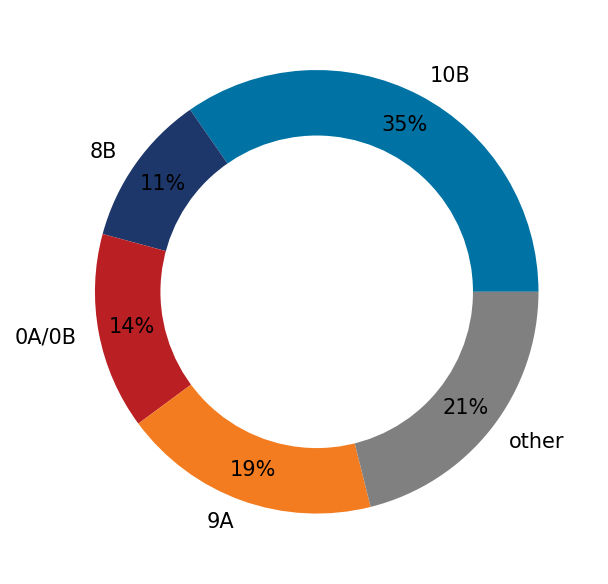

In [44]:
import seaborn
plt.rcParams['figure.dpi'] = 150

data = [t1l_sum_10B, t1l_sum_8B, t1l_sum_0A, t1l_sum_9A, t1l_sum_other]
keys = ['10B', '8B', '0A/0B', '9A', 'other']

colors = ["#0072A3", "#1E376B","#BA1F23","#F47C20", "#808080"] #"#d1b26f" "#650021"
cmap = sns.set_palette(sns.color_palette(colors))

plt.pie(data, labels = keys, autopct='%1.f%%', colors = cmap, labeldistance = 1.1, pctdistance = 0.85)
my_circle=plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)

# plt.savefig('t2r_club_outputs_donut.pdf', bbox_inches="tight")
plt.show()

In [45]:
# T2R 
[t2r_syn_per_conn, 
 t2r_sum_10B, 
 t2r_sum_8B, 
 t2r_sum_0A, 
 t2r_sum_9A, 
 t2r_sum_1A, 
 t2r_sum_other] = class_breakdown(4, t2r_club_df.pt_root_id.tolist()) 

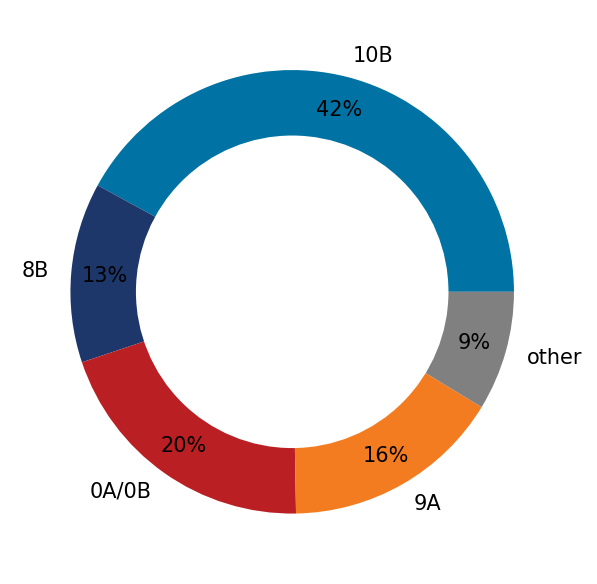

In [46]:
import seaborn
plt.rcParams['figure.dpi'] = 150

data = [t2r_sum_10B, t2r_sum_8B, t2r_sum_0A, t2r_sum_9A, t2r_sum_other]
keys = ['10B', '8B', '0A/0B', '9A', 'other']

colors = ["#0072A3", "#1E376B","#BA1F23","#F47C20", "#808080"] #"#d1b26f" "#650021"
cmap = sns.set_palette(sns.color_palette(colors))

plt.pie(data, labels = keys, autopct='%1.f%%', colors = cmap, labeldistance = 1.1, pctdistance = 0.85)
my_circle=plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)

# plt.savefig('t2r_club_outputs_donut.pdf', bbox_inches="tight")
plt.show()